### Backgound and Purpose

__[GDELT](https://www.gdeltproject.org/)__ claims to be "the largest, most comprehensive, and highest resolution open database of human society ever created". Started by Yahoo! and Georgetown University, the database contains content from broadcasts, print, and web news from nearly every country and in over 100 languanges. The database now contains a quarter billion georeferenced records that span a 30-year time period. The purpose of this tutorial is to demonstrate how to pull data from the GDELT database, efficiently extract data from a specified location in the world with specified event codes, and display the results interactively. 

### Retrieving GDELT Data

Before getting started, we'll need a number of packages. Later in the tutorial I'll load the packages required for generating the interactive plot and report. 

In [1]:
import pandas as pd               # gdelt data will be pulled into a Pandas dataframe
import numpy as np                # used for array and vector operations
import gdelt                      # for gdelt searches
import pygeodesy as pgd           # for geohash operations
import marisa_trie as mt          # for creating a trie data structure
import warnings                   # gdelt searches generates a bunch of warnings, so suppress them
warnings.filterwarnings('ignore')

Initiating and conducting the GDELT search is straight forward with the __[gdelt package](https://github.com/linwoodc3/gdeltPyR)__. We first instantiate the gdeltPyR object, and then specify the search. The gdelt package currently does not support sophisticated seraches, but that capability is in the works. This search returns all events between the specified dates, and places the results in a dataframe. The `normcols=True` parameter is optional, but it generates dataframe column titles that are more intuitive and a little easier to work with. My search pulled 47,573 reports from the timeframe of October 1-30, 2017 and took just a second or two. 

In [2]:
gd = gdelt.gdelt()     # instantiate the gdeltPyR object for searches
october = gd.Search(date=['2017 Oct 1','2017 Oct 30'], normcols=True) # normalize column names to SQL friendly format
print("The number of reports is", len(october))     # number of events returned

The number of reports is 47573


### Filtering the Data

These reports are from all over the world, so for this example, we'll filter them down by a list of event codes that would be specified by a user, and we'll filter them down to a specific area also specified by a user. The event codes we'll use are:
-  13: Make optimistic comment
-  14: Consider policy option
-  18: Make empathetic comment
-  19: Express accord
-  20: Make an appeal or request

The __[full list](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf)__ of event codes is also available from GDELT. For location, we'll use a latitude and longitude of 15.05, 1.82, which is in the Sahel of Niger near the borders of Mali, Burkina Faso, and Nigeria. We'll compare two methods for filtering the GDELT data based on location: using the haversine formula for calculating the great circle distance between our target location and the location associated with the GDELT events, and using geohashes for identifying events in the target and neighboring geohash cells. 

#### Haversine Method

For the haversine method, we'll specify a great circle distance of 300 km and return anything within that radius that also matches our even codes. The `haversine_funct` function is taken from a blog written by __[Sofia Heisler](https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6)__ that is a great post primarily about optimizing Pandas for speed. I made minor modifications to return distances in kilometers instead of miles. Vectorizing the function using `np.vectorize` significantly improves computational performance, which is especially important when working with large datasets. The `haver_subset` function takes our user-specified location, search distance, and event codes, and returns the filtered results.

In [3]:
def haversine_funct(lat1, lon1, lat2, lon2):
    # Calculates the great circle distance between two locations given in decimal degrees latitude and logitude
    kms = 3959*1.60934
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_km = kms * c
    return total_km

haver_vec = np.vectorize(haversine_funct)                      # vectorize the haversine function for speed

def haver_subset(df, x, y, z):
    '''Filters a dataframe based on a location, search radius, and event codes
    Inputs: 
        df: a dataframe containing GDELT search results
        x: a latitude, longitude tuple
        y: a distance in kilometers
        z: a list of event codes
    Returns a filtered dataframe'''
    df['eventrootcode'] = pd.to_numeric(df['eventrootcode'])   # convert codes from 040 to 40
    df = df[df['eventrootcode'].isin(z)]                       # filter by event code
    df['Dist'] = haver_vec(location[0], location[1], df['actiongeolat'].values, df['actiongeolong'].values) # calc distance
    df = df[df['Dist'] < y]                                    # filter by distance
    return df

location = (15.05, 1.82)                                       # user specified latitude, longitude
dist = 300                                                     # user specified search distance in km
ecodes = [13, 14, 18, 19, 20]                                  # user specified event codes

haver_df = haver_subset(october, location, dist, ecodes)       # call the filtering function
haver_df = haver_df.sort_values('Dist', ascending=True)        # sort by distance

# display select columns for the 10 closest events
haver_df[['globaleventid', 'eventrootcode', 'actiongeolat', 'actiongeolong', 'Dist']].head(10) 

,globaleventid,eventrootcode,actiongeolat,actiongeolong,Dist
10281,695524173,18,15.0522,1.83180,1.290563
10283,695524175,18,15.0522,1.83180,1.290563
9973,695523865,19,14.2117,1.45306,101.236042
30195,699403935,18,14.2117,1.45306,101.236042
9940,695523832,19,13.6951,1.74200,150.901012
9942,695523834,19,13.6951,1.74200,150.901012
9904,695523796,19,13.5167,2.11667,173.476446
25123,697422773,19,13.5167,2.11667,173.476446
36033,699726429,18,13.5167,2.11667,173.476446
39118,700767120,19,13.5167,2.11667,173.476446


In [4]:
print("The number of reports is", len(haver_df))     # number of events returned

The number of reports is 14


For our combination of search criteria, we ended up with 14 events. Scanning the results table, we're not getting any unwanted event codes or distances greater than our search radius, so the method appears to be functioning as intended.

#### Geohash Method

Geohashing is a system of locating something on the earth's surface that doesn't use latitude and longitude. The system is hierarchical in that the earth's surface is divided into a moderate number of squares using a grid system, and each square is assigned an alphanumeric character. If our target location is in grid "s", the geohash at this level is just "s". Each grid is then subdivided again, and each square in the second tier of grids is assigned a character. If our target location in this subgrid is in grid "1", the geohash is now "s1". The pattern can be repeated an arbitrary number of times with longer geohash  resulting in greater accuracy. The longer the match between the prefixes of two geohashes, the closer those two locations are to each other. One of the major advantages of this system is that it provides a fast way to pull all locations in a grid without having to directly calculate the distance between them. On the other hand, because of the order that the grids are numbered, if a location is on the edge of a grid, it may not necessarily have the same prefix as its neighbor. There are methods to work around this issue that I'll demonstrate.

One signficant difference between the procedure I'm using in the geohash method compared to the haversine method is that I'm adding the geohashes to the GDELT results dataframe outside of the filtering function. The GDELT search results include latitude and longitude, but not a geohash. I want to compare the performance of geohash filtering to great circle filtering, so I don't want to penalize the geohash function simply because the dataset does not already contain geohashes.

The procedure we'll use for the geohash method is as follows:
1. Vectorize the `get_geohash` function
2. Remove rows with NA in lat or long
3. Get a geohash based on lat and long for all remaining events
4. Get a geohash for the target loction
5. Filter by event code
6. Determine the number of geohash characters needed to return events within the specified distance of 300 km
7. Identify and incorporate the geohash grids that neighbor the target location
8. Filter the events based on the target and neighboring grids

When I first ran the code below, I got an error when generating a geohash if an event's latitude or logitude was missing, so we need to remove those rows. `pgd.geohash.encode` wouldn't accept dataframe columns as arguments, so I wrapped it in the `get_geohash` function and vectorized it as described previously.

Next we need to know how big of a grid square is returned as the geohash length increases. The __[Wikipedia entry](https://en.wikipedia.org/wiki/Geohash)__ for geohash includes a table of the information we need. With a target search radius of 300 km, we need a square with an error of at least 300. A geohash of length 3 has an error of 78 km, and a geohash of length 2 has an error of 638, so length 2 is what we need. 

Finally, we extract the first 2 characters of the target geohash with `ghash[0:hash_len]` and find all 2-character geohash areas adjacent to the target location with `pgd.geohash.neighbors(ghash[0:hash_len])`. This statement returns a list of 2-character-long geohashes taking advantage of a trie data structure using the __[marisa_trie](http://marisa-trie.readthedocs.io/en/latest/tutorial.html)__ to match prefeixes in a key. The next step is to find all of the full length geohashes that have one of these 2-letter prefixes, which is done in the `for` loop near the end of the function. Now that we have all full-length geohases with the matching prefixes, we can apply that list to filter our events database.

In [5]:
# drop rows with NA in lat or long
nona = october.dropna(axis=0, how='all', subset=(['actiongeolat', 'actiongeolong'])) 

def get_geohash(lat, long):
    return pgd.geohash.encode(lat, long)

def hash_subset(df, x, y, z):
    ghash = pgd.geohash.encode(x[0], x[1])               # get the geohash code for the location of interest
    df['eventrootcode'] = pd.to_numeric(df['eventrootcode'])     # needed to convert codes like 040 to 40
    df = df[df['eventrootcode'].isin(z)]                     # filter by event code
    if dist < 0.091: hash_len = 8                        # determine hash length needed
    elif dist < 0.076: hash_len = 7
    elif dist < 0.61: hash_len = 6
    elif dist < 2.4: hash_len = 5
    elif dist < 20: hash_len = 4
    elif dist < 78: hash_len = 3
    elif dist < 630: hash_len = 2
    elif dist < 2500: hash_len = 1
    hash_list = list(df['geohash'])                       # convert all event geohashes into a list
    trie = mt.Trie(hash_list)                             # make a trie out of the list
    prefix_list = [ghash[0:hash_len]]                     # start a list of all geohash areas we want to search
    neighbors = pgd.geohash.neighbors(ghash[0:hash_len])  # find all geohash areas that are adjacent to the target location
    nlist = list(neighbors.values())                      # convert the geohash object type to a list
    for item in nlist: prefix_list.append(str(item))      # create a list of all candidate geohash prefixes
    key_list = []
    for i in range(len(prefix_list)): 
        key_list = key_list + trie.keys(prefix_list[i])   # create a list of all candidate geohashes (the whole geohash)
    df = df[df['geohash'].isin(key_list)]                 # filter dataframe by matching geohashes
    return df

gh_vec = np.vectorize(get_geohash)                                      # vectorize the function
nona['geohash'] = gh_vec(nona['actiongeolat'], nona['actiongeolong'])   # get geohashes for all events
hash_df = hash_subset(nona, location, dist, ecodes)                     # filter the dataframe

# display select columns for the first 10 events
hash_df[['globaleventid', 'eventrootcode', 'actiongeolat', 'actiongeolong', 'geohash']].head(10)

,globaleventid,eventrootcode,actiongeolat,actiongeolong,geohash
127,695806559,19,8.31667,8.51667,s1qp3f18hg9k
171,695806603,19,8.31667,8.51667,s1qp3f18hg9k
172,695806604,19,6.80000,7.14670,s1jndtuhf5vu
178,695806610,19,12.26580,6.63738,s4htz0cjqnv5
840,695807272,13,12.26580,6.63738,s4htz0cjqnv5
841,695807273,19,8.31667,8.51667,s1qp3f18hg9k
874,695807306,13,12.26580,6.63738,s4htz0cjqnv5
1181,695807613,19,6.80000,7.14670,s1jndtuhf5vu
1182,695807614,19,10.52310,7.44028,s1v7c79ve04b
1225,695807657,19,6.80000,7.14670,s1jndtuhf5vu


Two things are immediately apparent from the events returned from the geohash function. First, there are more than the three that were returned from the haversine function. There were actually 171 events returned. Why is this? Recall that the geohash function searched in the target grid with an error of 638 km and in the 8 neighboring grids each with the same error. So we weren't returning only those events within 300 km, we retruned events from a much larger area. In fact, the dataframe returned from the geohash function doesn't have any column with distance information. So what's the point? Speed!

In [6]:
print("The number of reports is", len(hash_df))     # number of events returned

The number of reports is 171


### Performance Tests

Jupyter Notebook has a built-in magic called `%timeit` for performance testing that we'll use to compare the two functions. From the results below, the geohash function is about 4 times faster than the haversine function. While the difference of a few milliseconds may be trivial for our small example but significant for big datasets. The main advantage of the haversine function is that it only returns events within our specified distance. The main advantage of the geohash function is its speed. We'll combine these two aprroaches to take advantage of the strengths by first calling the geohash function to quickly narrow the events to the region and then calling the haversine function to filter those results down to the specified search radius.

In [7]:
# performance tests
%timeit haver_subset(nona, location, dist, ecodes)

73.6 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit hash_subset(nona, location, dist, ecodes)

16.5 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### A Case Example

In late April and early May 2017, New Orleans, LA removed four confederate monuments, so I've chosen the target location and dates accordingly. I'd like a search radius of 250 km, and I'll stick with the same event codes used above. The code below searches the GDELT database and filters the data by geohash first and haversine second. I've chosen __[Bokeh](https://bokeh.pydata.org/en/latest/)__ to visualize the results. The map shows all events within the search distance, and the table provides hyperlinks to the various news articles.

In [9]:
import config         # local file that contains my Google Maps API key
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, GMapOptions, BoxSelectTool, HoverTool
from bokeh.plotting import gmap
from bokeh.models.widgets import DataTable, HTMLTemplateFormatter, TableColumn
from bokeh.layouts import column
from bokeh.layouts import widgetbox

output_notebook()

Loading BokehJS ...

The folllowing code chuck gathers the data of interest.

In [10]:
location = (29.947499, -90.069654)  # downtown New Orleans
dist = 250                          # in km
ecodes = [13, 14, 18, 19, 20]       # gdelt event codes

#four confederate statues taken down on different dates in the time period in New Orleans
neworleans = gd.Search(date=['2017 April 24','2017 May 24'], normcols=True) # normalize column names to SQL friendly format
ghash = pgd.geohash.encode(location[0], location[1])    # get the geohash code for the location of interest
neworleans = neworleans.dropna(subset=(['actiongeolat', 'actiongeolong'])) # drop rows with no lat or long
neworleans['geohash'] = gh_vec(neworleans['actiongeolat'], neworleans['actiongeolong'])  # get geohashes for events
neworleans_hash_df = hash_subset(neworleans, location, dist, ecodes)            # call the geohash function
neworleans_final = haver_subset(neworleans_hash_df, location, dist, ecodes)     # call the haversine function
neworleans_final = neworleans_final.sort_values('Dist', ascending=True)         # sort results by distance from target location

Now visualize and display an interactive table.

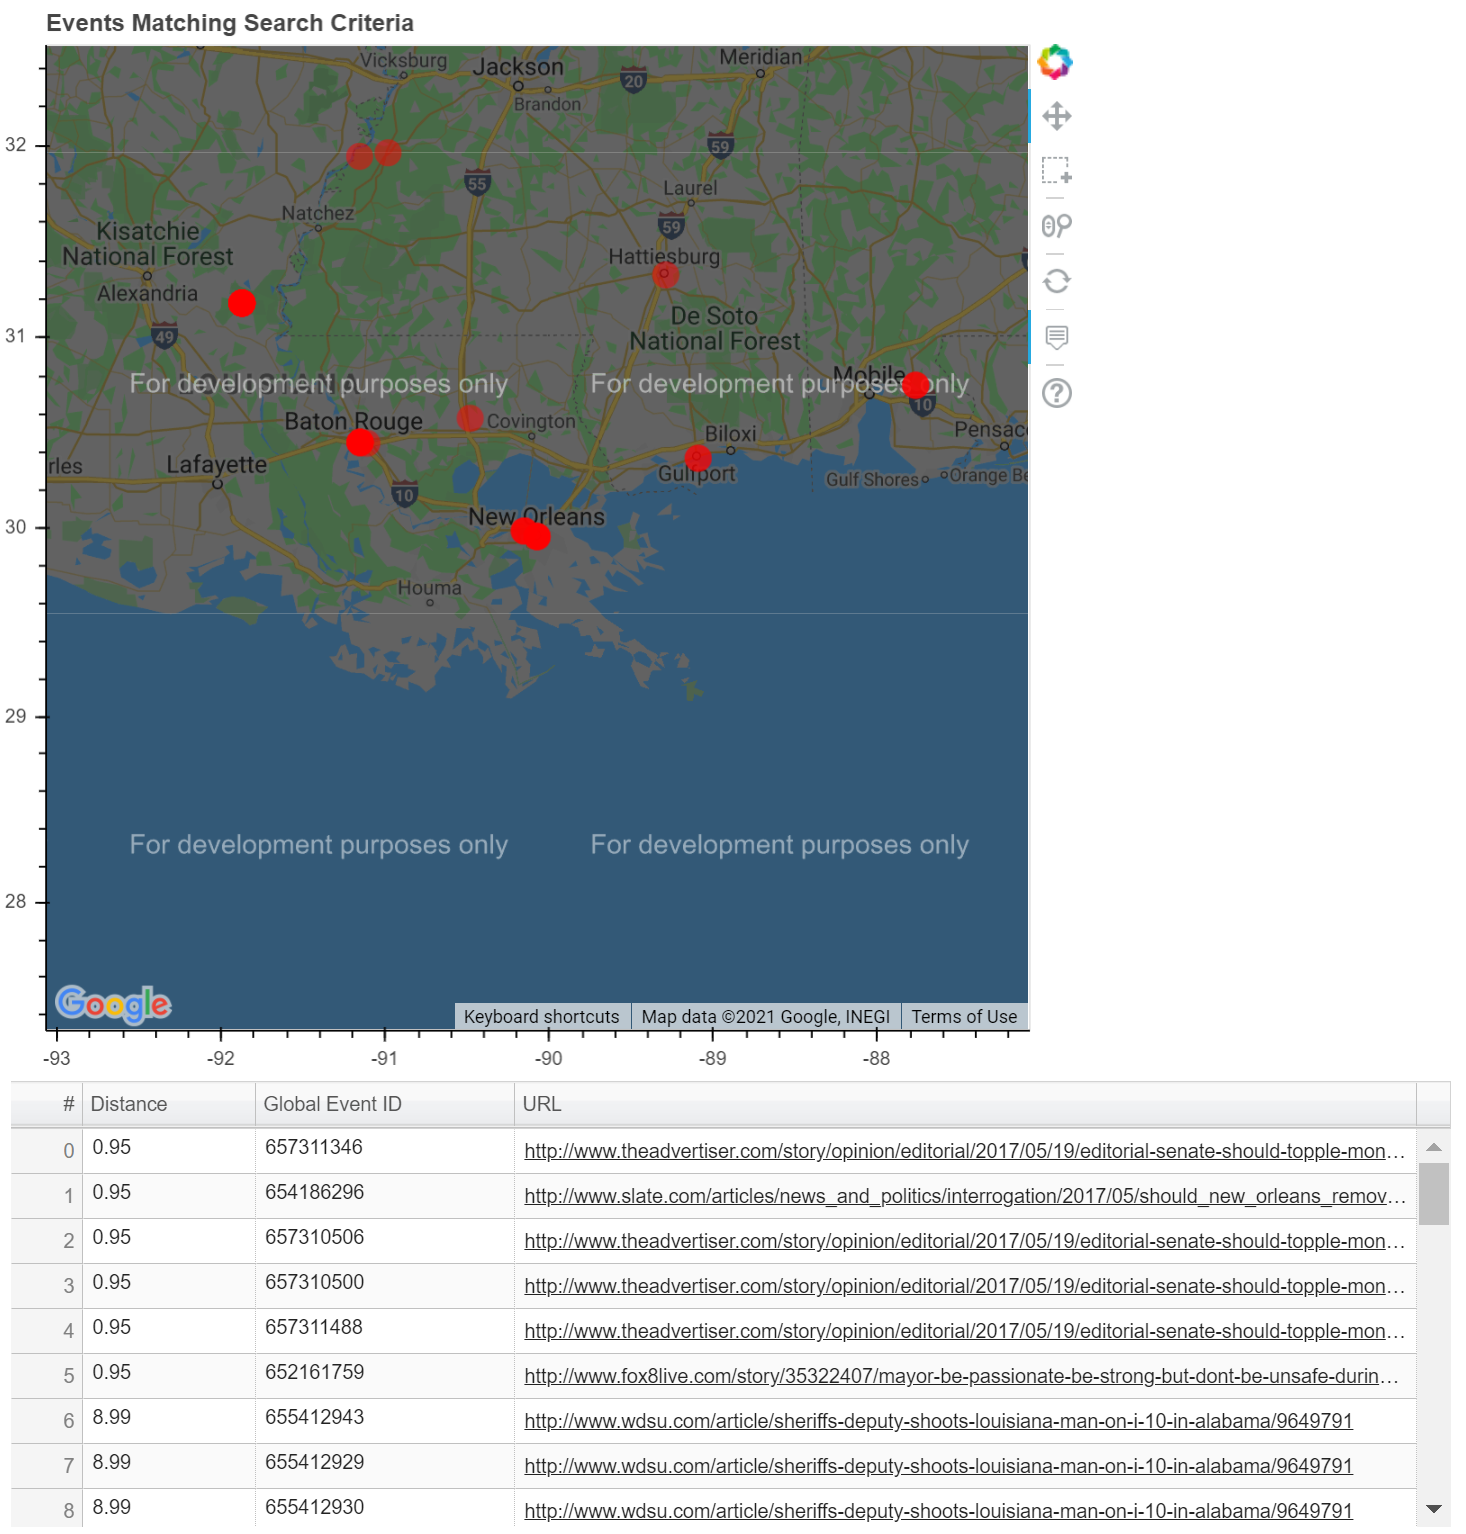

In [16]:
map_options = GMapOptions(lat=location[0], lng=location[1], map_type="roadmap", zoom=7)
p = gmap(config.GOOGLE_MAPS_API_KEY, map_options=map_options)
p.title.text = "Events Matching Search Criteria"
# For GMaps to function, Google requires you obtain and enable an API key:
source = ColumnDataSource(neworleans_final)
# create the glyph and the tools
p.circle(x="actiongeolong", y="actiongeolat", size=15, fill_color="red", fill_alpha=0.5, line_color=None, source=source)
p.add_tools(BoxSelectTool(), HoverTool())
# specify what is shown when hovering over a data point
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Global Event ID", "@globaleventid")]

data = dict(distance=neworleans_final['Dist'].round(2), eventid=neworleans_final['globaleventid'], 
            url=neworleans_final['sourceurl'])
source2 = ColumnDataSource(data)
columns = [TableColumn(field="distance", title='Distance', width=50),
          TableColumn(field="eventid", title='Global Event ID', width=80),
          TableColumn(field="url", title="URL", 
                      formatter=HTMLTemplateFormatter(template='<a href="<%= url %>"><%= value %></a>')), ]
data_table = DataTable(source=source2, columns=columns, width=800, height=250)

# Display the plot and the table
# show(column(p, widgetbox(data_table))) # use this code to display in a live sesstion

# GitHub won't display interactive graphics, so show a screeenshot instead.
from IPython import display
display.Image("./images/screenshot.png")